<a href="https://colab.research.google.com/github/dwgb93/TEI_WildfireSpread/blob/main/notebooks/Wildfire_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Erd&#337;s Institute Fall Boot Camp - Team Mahogany

We're using data from [this paper](https://arxiv.org/pdf/2112.02447.pdf) to predict where wildfires spread based on 12 features including wind, temperature, humidity, vegetation, and elevation.

This is a first code demo from [Google Research](https://github.com/google-research/google-research/tree/master/simulation_research/next_day_wildfire_spread) to visualize the data.

Each .tfrecord file consists of 100 64km by 64km grids with 12 features, described below.

For training, we will randomly sample a 32 by 32km grid to feed into logistic regerssion/neural network/etc. For testing we will either centre crop or just downsample the entire region.

Licensed under the Apache License, Version 2.0
# Imports

Import the required libraries.

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np

Note: This links your Google Drive to Colab. Useful if the data is stored in Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Common Functions (click to expand)

Run the following three cells to define the required library functions for loading the data.

In [3]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
# I recalculated the statistics based on the s
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    # Elevation
    'elevation' : (0.0, 3536.0, 896.5714, 842.6101),
    # Drought index - this claimed to be pressure, but it's Palmer Drought Severity Index
    # https://en.wikipedia.org/wiki/Palmer_drought_index
    # 0.1 percentile, 99.9 percentile
    'pdsi' : (-6.0559, 6.7432, -0.7729, 2.4407),
    # Normalized Difference Vegetation Index https://gisgeography.com/ndvi-normalized-difference-vegetation-index/
    'NDVI' : (-3826.0, 9282.0, 5350.6865, 2185.2192),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 19.2422, 0.3234289, 1.5336641),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0065263123, 0.003735537), #max changed to 1
    # Wind direction - degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th' : (0.0, 360.0, 146.6468, 3435.0725),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn' : (253.15, 299.6313, 281.85196, 18.4972), #min changed
    # -20 degree C, 99.9 percentile
    'tmmx' : (253.15, 317.3869, 297.71643, 19.4581), #min changed
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs' : (0.0, 9.7368, 3.6278, 1.3092),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc' : (0.0, 109.9254, 53.4690, 25.0980),
    # Population
    # min, 99.9 percentile
    'population' : (0.0, 2935.7548828125, 30.4603, 214.20015),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [4]:
DATA_STATS # Could use more readable names. Also, these are in a different order than below???

{'elevation': (0.0, 3536.0, 896.5714, 842.6101),
 'pdsi': (-6.0559, 6.7432, -0.7729, 2.4407),
 'NDVI': (-3826.0, 9282.0, 5350.6865, 2185.2192),
 'pr': (0.0, 19.2422, 0.3234289, 1.5336641),
 'sph': (0.0, 1.0, 0.0065263123, 0.003735537),
 'th': (0.0, 360.0, 146.6468, 3435.0725),
 'tmmn': (253.15, 299.6313, 281.85196, 18.4972),
 'tmmx': (253.15, 317.3869, 297.71643, 19.4581),
 'vs': (0.0, 9.7368, 3.6278, 1.3092),
 'erc': (0.0, 109.9254, 53.469, 25.098),
 'population': (0.0, 2935.7548828125, 30.4603, 214.20015),
 'PrevFireMask': (-1.0, 1.0, 0.0, 1.0),
 'FireMask': (-1.0, 1.0, 0.0, 1.0)}

Functions to crop randomly or from the centre.
I'd lean towards random cropping during training and centre cropping (or even downsampling) for testing.

In [5]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [6]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '[a-zA-Z]+'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'[a-zA-Z]+', key)
  if match:
    return match.group(1)
  raise ValueError('The provided key does not match the expected pattern: {key}')


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [7]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# Load the dataset.

In [8]:
file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_train*'
#Location within MY GDrive. Might not be the same for you. I don't know if you can link to my drive this way...

In [9]:
dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=64, #32 for training
      batch_size=14979, #14979 total
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=False)

TF Datasets are loaded lazily, so materialize the first batch of inputs and labels.

In [10]:
inputs, labels = next(iter(dataset))

In [ ]:
inputs[0] # Apaprently this changes each time we run iter

In [ ]:
# To get the total dataset, load train, set inputs train, load val, concat, load test, concat again
inputstrain = inputs
#inputsval = inputs
#inputstest = inputs
#inputtemp= tf.concat([inputstrain, inputsval], axis = 0)
#total_dataset= tf.concat([inputtemp, inputstest], axis = 0)

NameError: ignored

In [ ]:
inputtemp= tf.concat([inputstrain, inputsval], axis = 0)

In [ ]:
inputstest.shape #1877 is validation #1689 is test

In [ ]:
total_dataset.shape #18545

# Plotting function

In [11]:
n_rows = 10
n_features = inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

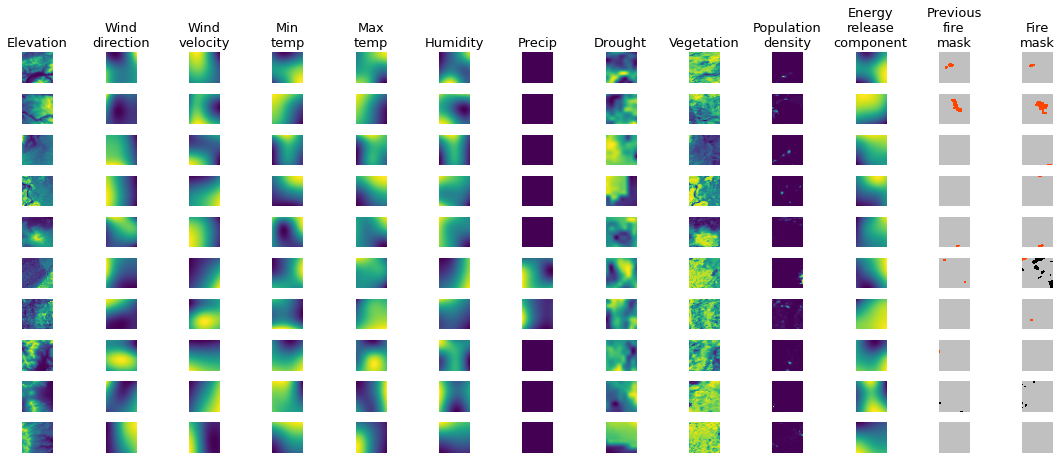

In [ ]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

# Exploratory Data Analysis

In [ ]:
for i in range(n_features):
    print(TITLES[i],"min:", np.min(inputs[:,:,:,i]))
    print(TITLES[i],"max:", np.max(inputs[:,:,:,i]))
    print(TITLES[i],"0.1%:", np.percentile(inputs[:,:,:,i], 0.1))
    print(TITLES[i],"99.9%:", np.percentile(inputs[:,:,:,i], 99.9))
    print(TITLES[i],"mean:", np.mean(inputs[:,:,:,i]))
    print(TITLES[i],"std:", np.std(inputs[:,:,:,i]))

#Numbers are close, but slightly different from the reported values above... data values calculated from entire dataset instead of just training set?
#That would be called data leakage, and is baaaad

Elevation min: -45.0
Elevation max: 4193.0
Elevation 0.1%: 0.0
Elevation 99.9%: 3536.0
Elevation mean: 896.56946
Elevation std: 842.6096
Wind
direction min: -505870.06
Wind
direction max: 37735.63
Wind
direction 0.1%: 0.0
Wind
direction 99.9%: 366.8275451660156
Wind
direction mean: 146.64648
Wind
direction std: 3435.0676
Wind
velocity min: -82.6531
Wind
velocity max: 103.2201
Wind
velocity 0.1%: 0.0
Wind
velocity 99.9%: 9.736795587539717
Wind
velocity mean: 3.6278431
Wind
velocity std: 1.3092144
Min
temp min: -444.69302
Min
temp max: 716.6276
Min
temp 0.1%: 0.0
Min
temp 99.9%: 299.6313171386719
Min
temp mean: 281.85226
Min
temp std: 18.49716
Max
temp min: 0.0
Max
temp max: 1229.8488
Max
temp 0.1%: 0.0
Max
temp 99.9%: 317.3868713378906
Max
temp mean: 297.71667
Max
temp std: 19.458052
Humidity min: -0.1289879
Humidity max: 0.08553028
Humidity 0.1%: 0.0
Humidity 99.9%: 0.019478965550661087
Humidity mean: 0.006526322
Humidity std: 0.0037355388
Precip min: -167.4483
Precip max: 56.21477
Pre

In [ ]:
# Print 4 number summary (min, max, mean, std) of the entire dataset for easy copypasta-ing
for i in range(n_features):
    print(TITLES[i])
    print("'",INPUT_FEATURES[i],"' : (",np.percentile(inputs[:,:,:,i], 0.1), ", ",np.percentile(inputs[:,:,:,i], 99.9),", ",np.mean(inputs[:,:,:,i]),", ",np.std(inputs[:,:,:,i]),"),",sep='')

#Numbers are close, but slightly different from the reported values above... data values calculated from entire dataset instead of just training set?
#That would be called data leakage, and is baaaad

Elevation
'elevation' : (0.0, 3536.0, 896.56946, 842.6096),
Wind
direction
'th' : (0.0, 366.8275451660156, 146.64648, 3435.0676),
Wind
velocity
'vs' : (0.0, 9.736795587539717, 3.6278431, 1.3092144),
Min
temp
'tmmn' : (0.0, 299.6313171386719, 281.85226, 18.49716),
Max
temp
'tmmx' : (0.0, 317.3868713378906, 297.71667, 19.458052),
Humidity
'sph' : (0.0, 0.019478965550661087, 0.006526322, 0.0037355388),
Precip
'pr' : (-0.12988853585720062, 19.242182199478265, 0.3234287, 1.5336617),
Drought
'pdsi' : (-6.055873533248901, 6.743183135986328, -0.7728712, 2.4407184),
Vegetation
'NDVI' : (-3826.0, 9282.0, 5350.6753, 2185.2192),
Population
density
'population' : (0.0, 2935.7548828125, 30.460266, 214.20052),
Energy
release
component
'erc' : (0.0, 109.92542266845703, 53.46917, 25.097977),
Previous
fire
mask
'PrevFireMask' : (-1.0, 1.0, -0.002722855, 0.13831188),


# Data Counts

We want to figure out how much fire vs no fire vs no data we have


In [ ]:
y, idx, count = tf.unique_with_counts(tf.reshape(inputs[:,:,:,11],[len(inputs)*64*64]))
print(y)
print(count)

tf.Tensor([ 0.  1. -1.], shape=(3,), dtype=float32)
tf.Tensor([60179816   503555   670613], shape=(3,), dtype=int32)


In [ ]:
print("No Fire:", count[0]/sum(count))
print("Fire:", count[1]/sum(count))
print("No Data:", count[2]/sum(count))

No Fire: tf.Tensor(0.9808624000684292, shape=(), dtype=float64)
Fire: tf.Tensor(0.008207372482934442, shape=(), dtype=float64)
No Data: tf.Tensor(0.010930227448636424, shape=(), dtype=float64)


Compare to next day:

In [ ]:
y_label, idx_label, count_label = tf.unique_with_counts(tf.reshape(labels,[len(labels)*64*64]))
print(y_label)
print(count_label)

tf.Tensor([ 0.  1. -1.], shape=(3,), dtype=float32)
tf.Tensor([59254803   658270  1440911], shape=(3,), dtype=int32)


In [ ]:
print("No Fire:", count_label[0]/sum(count_label))
print("Fire:", count_label[1]/sum(count_label))
print("No Data:", count_label[2]/sum(count_label))

No Fire: tf.Tensor(0.9657857426177899, shape=(), dtype=float64)
Fire: tf.Tensor(0.010729050618782963, shape=(), dtype=float64)
No Data: tf.Tensor(0.023485206763427132, shape=(), dtype=float64)


Notably, the amount of fire grows from one day to the next (not surpsising, it's fire)

The amount of missing data also grows (probably due to smoke cover)

In [ ]:
(count_label - count)/count

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-0.01537082,  0.30724548,  1.14864758])>

Fire grows by 30+%, missing data more than doubles, regular region shrinks by 1.5%

---



# Establishing a Baseline

Based on the numbers above, we can achieve a 96.6% accuracy (94.8% on 32*32 data) by just claiming every pixel is No fire. Obviously, this isn't what we want to do. We're going to calculate precision and recall (and probably AUC).


To this end, let's start by setting a baseline of prediction = yesterday's fire.

In [ ]:
## now we can import the confusion matrix
from sklearn.metrics import confusion_matrix

In [ ]:
# Baseline = yesterday prediction
preds = tf.reshape(inputs[:,:,:,11],[len(inputs)*64*64])

# Baseline = No fire at all
#preds = tf.zeros(len(inputs)*64*64)

# Baseline = The world is burning
#preds = tf.ones(len(inputs)*64*64)

In [ ]:
## just like mse, actual then prediction
cum = confusion_matrix(tf.reshape(labels,[len(inputs)*64*64]), preds)

In [ ]:
cum

array([[       0,  1440911,        0],
       [       0, 59254803,        0],
       [       0,   658270,        0]])

In [ ]:
## Calculate the confusion matrix here

TN = cum[1,1]
FP = cum[1,2]
FN = cum[2,1]
TP = cum[2,2]

In [ ]:
## calculate recall and precision here
print("The baseline precision is", 
         np.round(TP/(FP + TP), 4))

print("The baseline recall is", 
         np.round(TP/(FN + TP), 4))

print("The baseline accuracy (fire v no fire only) is", 
         np.round((TP + TN)/(TN + FN + FP + TP), 4))

The baseline precision is nan
The baseline recall is 0.0
The baseline accuracy (fire v no fire only) is 0.989


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


There's an idea of a 3-way precision/recalls score that I'm not totally on board with.

We're not ever *trying* to predict "no data" so it shouldn't count as a success when we get it right.

We can either assume "no data" = no fire, and go from there, or predict just fire vs no fire, and if we don't know, ignore that particular data point (as calculated above).

In [ ]:
from sklearn.metrics import precision_score, recall_score
## print the precision and recall here
print("The training precision is",
         np.round(precision_score(tf.reshape(labels,[len(inputs)*64*64]), preds, average = None),4))

print("The training recall is",
         np.round(recall_score(tf.reshape(labels,[len(inputs)*64*64]), preds, average = None),4))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The training precision is [0.     0.9658 0.    ]
The training recall is [0. 1. 0.]


Can I make a table of values?

Baselines: 

1.   Default = yesterday's guess
    *   Precision: .3462
    *   Recall: 0.2636
    *   "Accuracy" = 0.9864
2.   No Fire
    *   Precision: NaN
    *   Recall: 0
    *   "Accuracy" = 0.989
3.   All Fire
    *   Precision: 0.011
    *   Recall: 1.0 WOO!
    *   "Accuracy" = 0.011




# More EDA

In [12]:
n_features = 12
# X = tf.reshape(inputs, [len(inputs)*64*64,n_features]).numpy()
X = inputs.numpy().reshape([len(inputs)*64*64,n_features])

In [ ]:
corr = np.corrcoef(X.T)

In [ ]:
corr #I made this a pretty picture in Sheets

array([[ 1.00000000e+00,  8.95204117e-03,  4.16158162e-02,
        -4.91206846e-02,  3.83518943e-03, -4.53742269e-01,
        -9.69577595e-02, -2.14973558e-01, -1.83327236e-01,
        -1.10397952e-01,  6.31103648e-01,  1.46194745e-02],
       [ 8.95204117e-03,  1.00000000e+00,  5.67104146e-03,
        -1.77020466e-03, -4.25939415e-04, -1.63066750e-02,
        -1.46111917e-02, -1.91747904e-03, -6.54134915e-03,
         9.17179610e-04,  1.01825472e-02,  2.90504675e-03],
       [ 4.16158162e-02,  5.67104146e-03,  1.00000000e+00,
         5.65282480e-02,  5.48344452e-02, -1.94125222e-01,
         3.86950813e-02, -8.02998691e-02, -1.31672077e-01,
        -6.56712562e-03,  1.37506083e-03, -2.26329815e-02],
       [-4.91206846e-02, -1.77020466e-03,  5.65282480e-02,
         1.00000000e+00,  9.84119775e-01,  3.76634443e-01,
         4.10925264e-02,  2.40477411e-03,  1.85137600e-01,
         2.30260928e-02,  1.75619827e-01,  5.97513381e-02],
       [ 3.83518943e-03, -4.25939415e-04,  5.4834445

In [13]:
y = labels.numpy().reshape([len(labels)*64*64])

In [16]:
X[:,0].shape

(61353984,)

In [18]:
# correlation of each feature with the output label
# Unsurprisingly, previous fire mask has the highest correlation, with ERC also being high, then temperature
# Similarly, precipitation is most negatively correlated. Go figure.

for i in range(n_features):
  print(TITLES[i],"correlation")
  print(np.corrcoef(X[:,i],y)[0,1])

Elevation correlation
0.028568062019845446
Wind
direction correlation
0.0003219819269452545
Wind
velocity correlation
-0.021916698304398744
Min
temp correlation
0.062038396070440094
Max
temp correlation
0.0721865397949106
Humidity correlation
0.017075443623510798
Precip correlation
-0.10273612830279936
Drought correlation
-0.042421955357049144
Vegetation correlation
0.03244042399383913
Population
density correlation
-0.0009890656273104912
Energy
release
component correlation
0.1210209095489826
Previous
fire
mask correlation
0.18589915512068467


TO DO:
visualize predictions
maybe only predict fire/no fire and avoid missing data predictions (how to do this? How to measure accuracy/error?

Correlation coefficients
linear regression should theoretically work - give this a shot

we need to write up some of this - stakeholders and such

#Histograms?